In [38]:
run_gridsearch = False
skip_best_model_train = True
hyperparam_csv_file = "calpella_mts2_hyperparams.csv"

In [39]:
import sys
import os
import itertools
current_dir = os.getcwd()
print(current_dir)

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all


In [40]:
library_path = os.path.join('..', '..', '..','..','UCB-USACE-LSTMs')
sys.path.insert(0, library_path)
print(sys.path)

['../../../../UCB-USACE-LSTMs', '/Users/canruso/Applications/DataSpell.app/Contents/plugins/python-ce/helpers-pro/jupyter_debug', '/Users/canruso/Applications/DataSpell.app/Contents/plugins/python-ce/helpers/pydev', '../../../../UCB-USACE-LSTMs', '/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all', '/Users/canruso/Desktop', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python310.zip', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/lib-dynload', '', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/setuptools/_vendor', '/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs', '/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs']


In [41]:
from pathlib import Path
from neuralhydrology.evaluation.metrics import *
from UCB_training.UCB_train import UCB_trainer
from UCB_training.UCB_utils import (combinedPlot, fancyCombinedPlot, combinedPlotFromDf, fancyCombinedPlotFromDf)

In [42]:
# Dynamically find the repo root from the current working directory
current_path = os.getcwd()
library_path = current_path.split('UCB-USACE-LSTMs')[0] + 'UCB-USACE-LSTMs'

# Construct the target path
target_path = os.path.join(library_path, 'UCB_training', 'models', 'calpella_all')

# Verify if the directory exists before changing
if os.path.exists(target_path):
    os.chdir(target_path)
    print("Current Working Directory:", os.getcwd())
    print("Train Basin File Exists:", os.path.exists("calpella")) 
else:
    print(f"Error: The target path '{target_path}' does not exist.")

Current Working Directory: /Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all
Train Basin File Exists: True


In [43]:
path_to_csv = Path(library_path +'/russian_river_data')
path_to_yaml = Path("calpella_mtslstm2.yaml")
path_to_physics_data_1D = Path(library_path + "/russian_river_data/Calpella_daily.csv")
path_to_physics_data_1H = Path(library_path + "/russian_river_data/Calpella_hourly.csv")

In [44]:
features_with_physics = [
        "EF RUSSIAN 20 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
        "EF RUSSIAN 20 PRECIP-INC SCREENED",
        "POTTER VALLEY CA FLOW USGS_ADJUSTED",
        "UKIAH CA HUMIDITY USAF-NOAA",
        "UKIAH CA SOLAR RADIATION USAF-NOAA",
        "UKIAH CA TEMPERATURE USAF-NOAA",
        "UKIAH CA WINDSPEED USAF-NOAA",
        # Physics columns (daily)
        "Capella Gage FLOW",
        "EF Russian 20 ET-POTENTIAL",
        "EF Russian 20 FLOW",
        "EF Russian 20 FLOW-BASE",
        "EF Russian 20 INFILTRATION",
        "EF Russian 20 PERC-SOIL",
        "EF Russian 20 SATURATION FRACTION"]


In [45]:
hyperparam_space = {
    "hidden_size": [64, 128],
    "seq_length_1D": [90, 180],
    "seq_length_1H": [168, 336],       
    "num_layers": [1],
    "epochs": [16, 32]
}

fixed_dropout = 0.4
no_physics_results = []
physics_results = []

In [46]:
if run_gridsearch or not os.path.exists(hyperparam_csv_file):
    for (hs, seqD, seqH, nl, ep) in itertools.product(
            hyperparam_space["hidden_size"],
            hyperparam_space["seq_length_1D"],
            hyperparam_space["seq_length_1H"],
            hyperparam_space["num_layers"],
            hyperparam_space["epochs"]
    ):

        hp = {
            "hidden_size": hs,
            "seq_length": {"1D": seqD, "1H": seqH},
            "num_layers": nl,
            "epochs": ep,
            "output_dropout": fixed_dropout
        }

        print(f"\nNoPhysics MTS: {hp}")
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp,
            input_features=None,
            physics_informed=False,
            physics_data_file=None,
            hourly=True,  
            extend_train_period=False,
            gpu=-1,
            is_mts = True
        )
        trainer.train()
        csv_1d, metrics_1d = trainer.results(period="validation", mts_trk="1D")
        csv_1h, metrics_1h = trainer.results(period="validation", mts_trk="1H")

        row_data = {
            "hidden_size": hs,
            "seq_length_1D": seqD,
            "seq_length_1H": seqH,
            "num_layers": nl,
            "epochs": ep,
            "output_dropout": fixed_dropout,
            "NSE_1D": metrics_1d.get("NSE", 0),
            "NSE_1H": metrics_1h.get("NSE", 0)
        }
        no_physics_results.append(row_data)

    df_no_physics = pd.DataFrame(no_physics_results)
    df_no_physics.sort_values(by="NSE_1D", ascending=False, inplace=True)
    df_no_physics.reset_index(drop=True, inplace=True)
else:
    print("Skipping grid search!")

Skipping grid search!


In [47]:
if run_gridsearch or not os.path.exists(hyperparam_csv_file):
    for (hs, seqD, seqH, nl, ep) in itertools.product(
            hyperparam_space["hidden_size"],
            hyperparam_space["seq_length_1D"],
            hyperparam_space["seq_length_1H"],
            hyperparam_space["num_layers"],
            hyperparam_space["epochs"]):

        hp = {
            "hidden_size": hs,
            "seq_length": {"1D": seqD, "1H": seqH},
            "num_layers": nl,
            "epochs": ep,
            "output_dropout": fixed_dropout
        }

        print(f"\nPhysics MTS: {hp}")
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp,
            input_features=features_with_physics,
            physics_informed=True,
            physics_data_file=path_to_physics_data_1H,
            hourly=True,
            extend_train_period=False,
            gpu=-1,
            is_mts = True
        )
        trainer.train()
        csv_1d, metrics_1d = trainer.results(period="validation", mts_trk="1D")
        csv_1h, metrics_1h = trainer.results(period="validation", mts_trk="1H")

        row_data = {
            "hidden_size": hs,
            "seq_length_1D": seqD,
            "seq_length_1H": seqH,
            "num_layers": nl,
            "epochs": ep,
            "output_dropout": fixed_dropout,
            "NSE_1D": metrics_1d.get("NSE", 0),
            "NSE_1H": metrics_1h.get("NSE", 0)
        }
        physics_results.append(row_data)
    df_physics = pd.DataFrame(physics_results)
    df_physics.sort_values(by="NSE_1D", ascending=False, inplace=True)
    df_physics.reset_index(drop=True, inplace=True)
    best_no_phys = df_no_physics.iloc[0].to_dict()
    best_phys = df_physics.iloc[0].to_dict()
    best_no_phys["model_type"] = "no_physics"
    best_phys["model_type"] = "physics"
    best_params_df = pd.DataFrame([best_no_phys, best_phys])
    best_params_df.to_csv(hyperparam_csv_file, index=False)
else:
    print("Skipping grid search!")

Skipping grid search!


In [48]:
if run_gridsearch:
    print(df_no_physics.iloc[0:4])
    df_no_physics.to_csv("calpella_mts2_no_physics_gridsearch.csv", index=False)

In [49]:
if run_gridsearch:
    print(df_physics.iloc[0:4])
    df_physics.to_csv("calpella_mts2_physics_gridsearch.csv", index=False)

In [50]:
if os.path.exists(hyperparam_csv_file):
    best_params_df = pd.read_csv(hyperparam_csv_file)
    best_no_phys = best_params_df.query("model_type == 'no_physics'").iloc[0].to_dict()
    best_phys = best_params_df.query("model_type == 'physics'").iloc[0].to_dict()

    best_no_physics_params = {
        "epochs": int(best_no_phys["epochs"]),
        "hidden_size": int(best_no_phys["hidden_size"]),
        "seq_length": {
            "1D": int(best_no_phys["seq_length_1D"]),
            "1H": int(best_no_phys["seq_length_1H"])
        },
        "num_layers": int(best_no_phys["num_layers"]),
        "output_dropout": float(best_no_phys["output_dropout"])
    }

    best_physics_params = {
        "epochs": int(best_phys["epochs"]),
        "hidden_size": int(best_phys["hidden_size"]),
        "seq_length": {
            "1D": int(best_phys["seq_length_1D"]),
            "1H": int(best_phys["seq_length_1H"])
        },
        "num_layers": int(best_phys["num_layers"]),
        "output_dropout": float(best_phys["output_dropout"])
    }
    print("Loaded best hyperparams from CSV:")
    print("Best NO-PHYS:", best_no_physics_params)
    print("Best PHYS:", best_physics_params)
else:
    print(f"Error: {hyperparam_csv_file} not found. Did you run gridsearch?")

Loaded best hyperparams from CSV:
Best NO-PHYS: {'epochs': 32, 'hidden_size': 64, 'seq_length': {'1D': 180, '1H': 336}, 'num_layers': 1, 'output_dropout': 0.4}
Best PHYS: {'epochs': 32, 'hidden_size': 64, 'seq_length': {'1D': 90, '1H': 168}, 'num_layers': 1, 'output_dropout': 0.4}


In [51]:
if not skip_best_model_train:
    noPhysValTrainer = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=True,
        extend_train_period=False,
        gpu=-1,
        is_mts = True
    )
    noPhysValTrainer.train()
    noPhys_val_csv_1D, noPhys_val_metrics_1D = noPhysValTrainer.results(period="validation", mts_trk="1D")
    noPhys_val_csv_1H, noPhys_val_metrics_1H = noPhysValTrainer.results(period="validation", mts_trk="1H")
    print("NO-PHYS VAL 1D => NSE =", noPhys_val_metrics_1D.get("NSE", None))
    print("NO-PHYS VAL 1H => NSE =", noPhys_val_metrics_1H.get("NSE", None))

In [52]:
if not skip_best_model_train:
    physValTrainer = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file=path_to_physics_data_1H,
        hourly=True,
        extend_train_period=False,
        gpu=-1,
        is_mts = True
    )
    physValTrainer.train()
    phys_val_csv_1D, phys_val_metrics_1D = physValTrainer.results(period="validation", mts_trk="1D")
    phys_val_csv_1H, phys_val_metrics_1H = physValTrainer.results(period="validation", mts_trk="1H")
    print("PHYS VAL 1D => NSE =", phys_val_metrics_1D.get("NSE", None))
    print("PHYS VAL 1H => NSE =", phys_val_metrics_1H.get("NSE", None))

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB

[INFO] Wrote metrics CSV: calpella_mts2_val_metrics_1D.csv


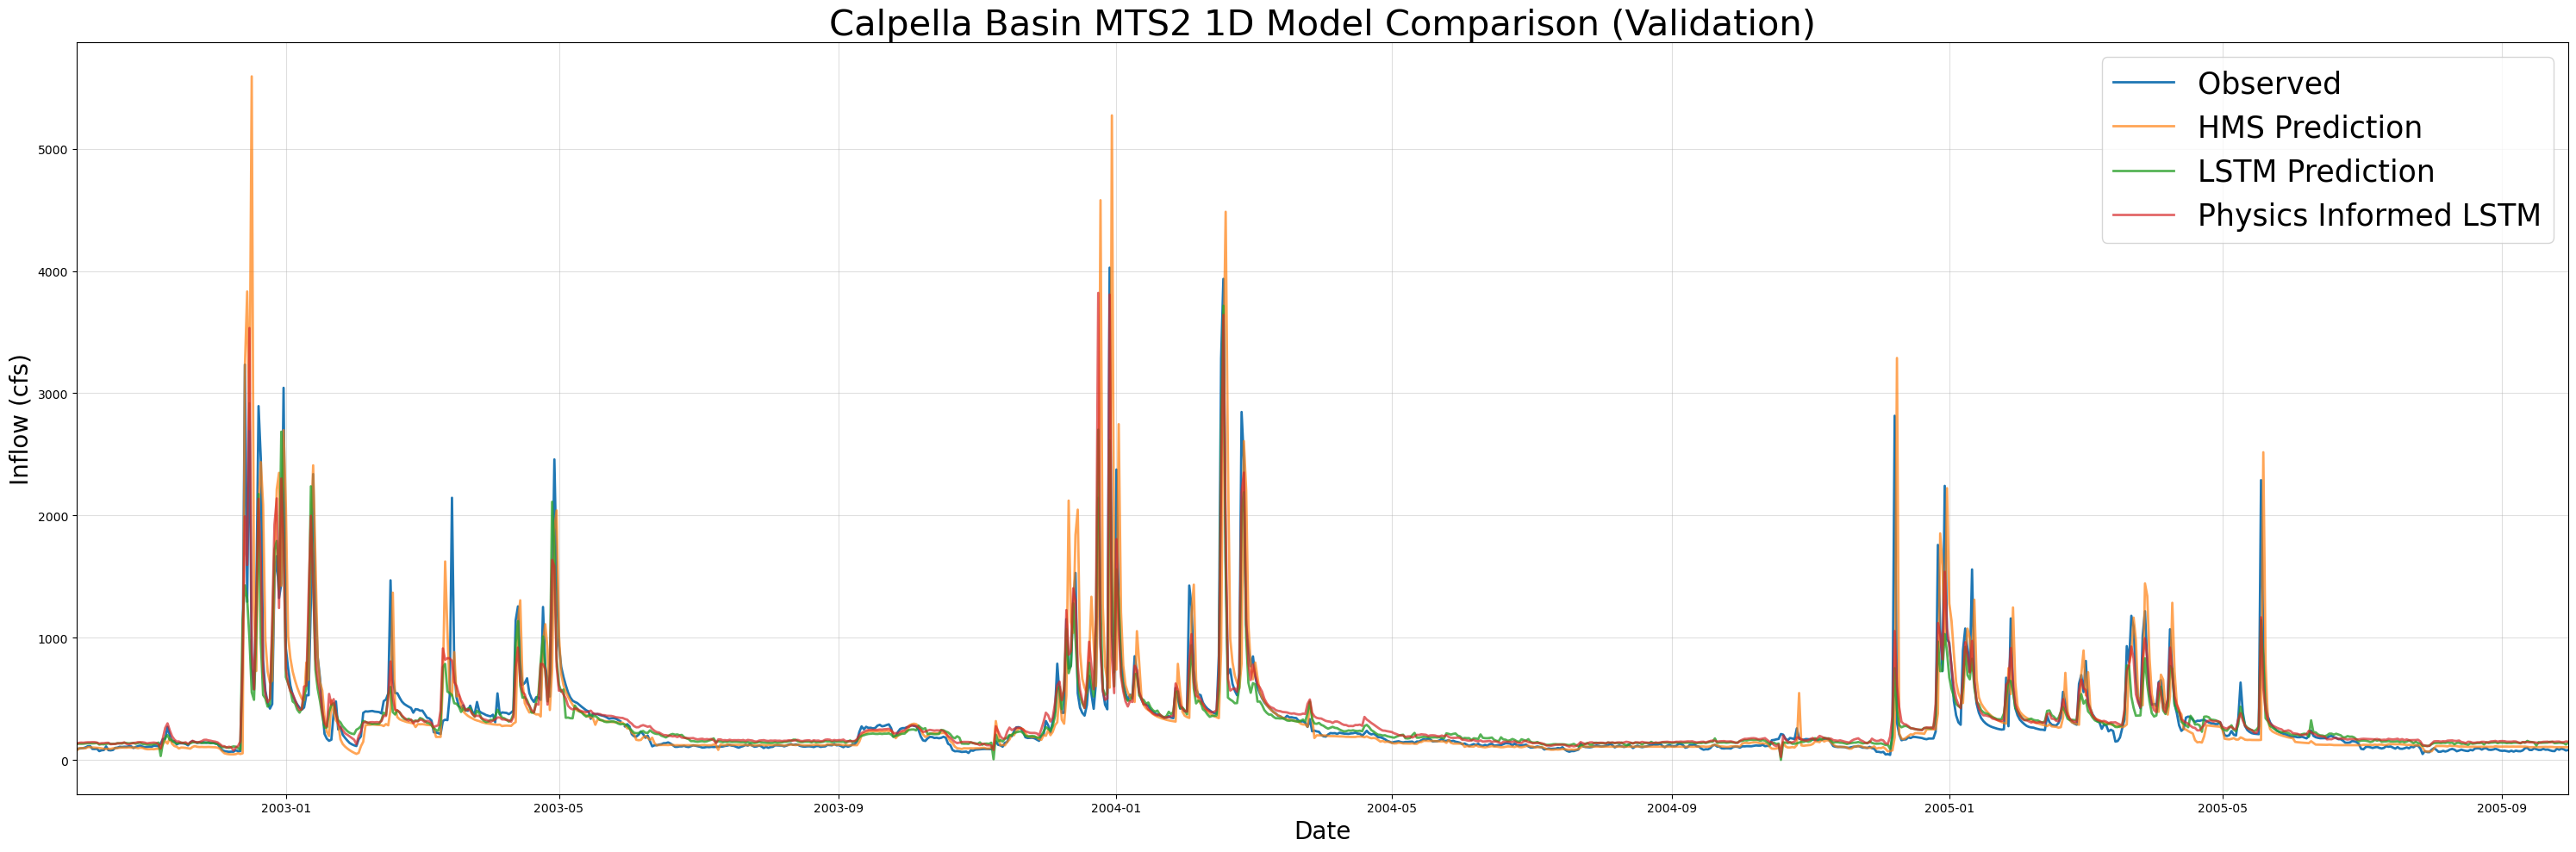

In [53]:
if not skip_best_model_train:
    print("\nPlotting combined MTS results (Validation, 1D)...")
    combinedPlot(
        lstm_results=noPhys_val_csv_1D,
        lstmPhysics_results=phys_val_csv_1D,
        HMS_results=path_to_physics_data_1D,
        title="Calpella Basin MTS2 1D Model Comparison (Validation)",
        fName="calpella_mts2_val_metrics_1D.csv",
        plot_filename="calpella_mts2_val_1D_comparison.png",
        timeseries_filename="calpella_mts2_val_1D_combined_ts.csv"
    )
else:
    combined_df_1D = pd.read_csv("calpella_mts2_val_1D_combined_ts.csv")
    combinedPlotFromDf(
        combined_df_1D,
        title="Calpella Basin MTS2 1D Model Comparison (Validation)",
        fName="calpella_mts2_val_metrics_1D.csv"
    )

In [54]:
if not skip_best_model_train:
    fancyCombinedPlot(
        lstm_results=noPhys_val_csv_1D,
        lstmPhysics_results=phys_val_csv_1D,
        HMS_results=path_to_physics_data_1D,
        title="Calpella Basin MTS2 1D Model Comparison (Validation)",
        fName="calpella_mts2_val_metrics_1D.csv",
        timeseries_filename="calpella_mts2_val_1D_combined_ts.csv"
    )
else:
    fancyCombinedPlotFromDf(
        combined_df_1D,
        title="Calpella Basin MTS2 1D Model Comparison (Validation)",
        fName="calpella_mts2_val_metrics_1D.csv"
    )

[INFO] Wrote metrics CSV: calpella_mts2_val_metrics_1D.csv


/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB

[INFO] Wrote metrics CSV: calpella_mts2_val_metrics_1H.csv


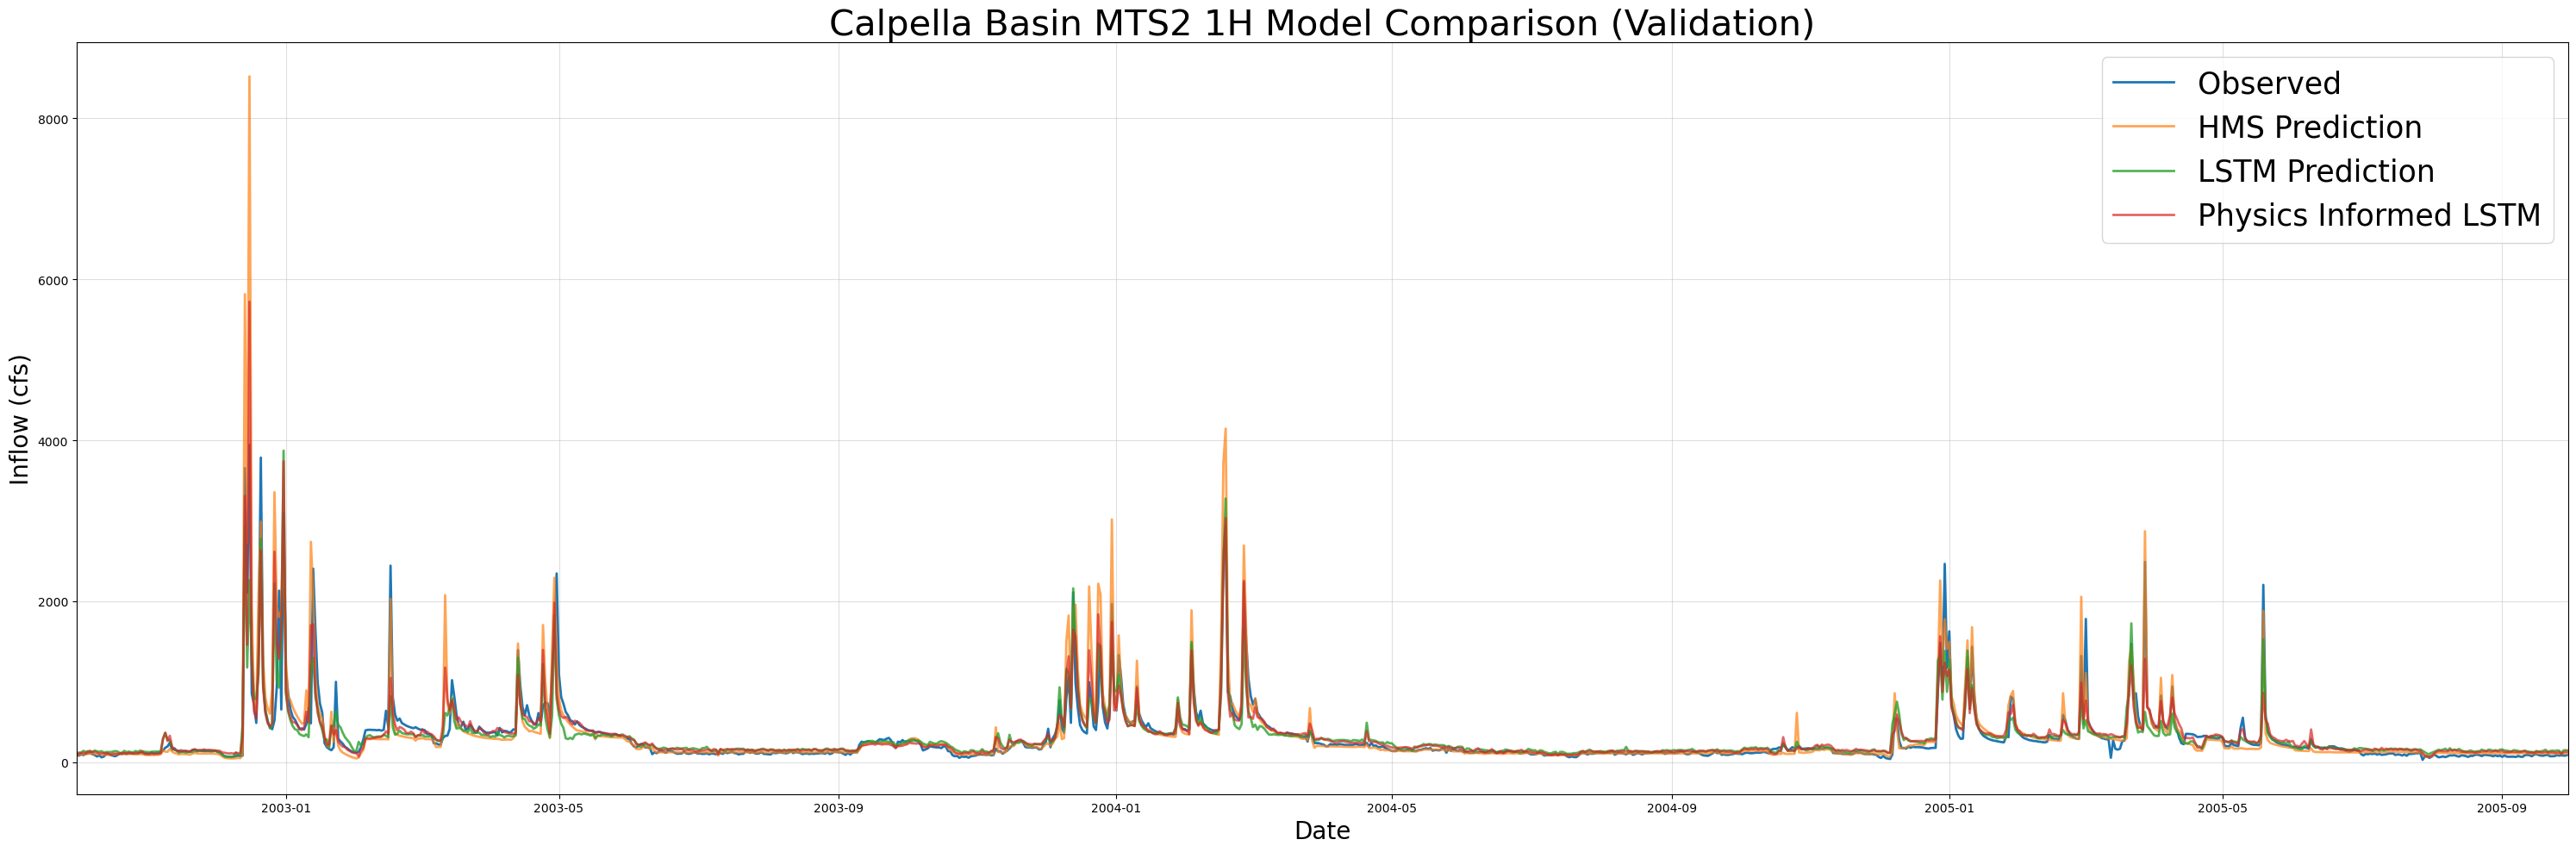

In [55]:
if not skip_best_model_train:
    print("\nPlotting combined MTS results (Validation, 1H)...")
    combinedPlot(
        lstm_results=noPhys_val_csv_1H,
        lstmPhysics_results=phys_val_csv_1H,
        HMS_results=path_to_physics_data_1H,
        title="Calpella Basin MTS2 1H Model Comparison (Validation)",
        fName="calpella_mts2_val_metrics_1H.csv",
        plot_filename="calpella_mts2_val_1H_comparison.png",
        timeseries_filename="calpella_mts2_val_1H_combined_ts.csv"
    )
else:
    combined_df_1H = pd.read_csv("calpella_mts2_val_1H_combined_ts.csv")
    combinedPlotFromDf(
        combined_df_1H,
        title="Calpella Basin MTS2 1H Model Comparison (Validation)",
        fName="calpella_mts2_val_metrics_1H.csv"
    )

In [56]:
if not skip_best_model_train:
    fancyCombinedPlot(
        lstm_results=noPhys_val_csv_1H,
        lstmPhysics_results=phys_val_csv_1H,
        HMS_results=path_to_physics_data_1H,
        title="Calpella Basin MTS2 1H Model Comparison (Validation)",
        fName="calpella_mts2_val_metrics_1H.csv",
        timeseries_filename="calpella_mts2_val_1H_combined_ts.csv"
    )
else:
    fancyCombinedPlotFromDf(
        combined_df_1H,
        title="Calpella Basin MTS2 1H Model Comparison (Validation)",
        fName="calpella_mts2_val_metrics_1H.csv"
    )

[INFO] Wrote metrics CSV: calpella_mts2_val_metrics_1H.csv


/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB

In [57]:
if skip_best_model_train:
    val_metrics = pd.read_csv("calpella_mts2_val_metrics_1D.csv")
    print(val_metrics)

     Unnamed: 0            HMS          LSTM  Physics_Informed_LSTM
0           NSE       0.115942      0.775707               0.836247
1           MSE  151387.681984  38408.295901           28041.354359
2          RMSE     389.085700    195.980346             167.455529
3           KGE       0.590160      0.732277               0.827020
4     Alpha-NSE       1.224230      0.756506               0.858270
5      Beta-KGE       1.045429      0.976797               1.054773
6      Beta-NSE       0.034762     -0.017755               0.041913
7     Pearson-r       0.659962      0.891152               0.917329
8           FHV      18.921339    -22.675327             -13.297718
9           FMS      -9.139605    -23.645435             -25.468540
10          FLV       5.213867  -2129.277064            -113.671470
11  Peak-Timing       1.400000      0.200000               0.200000
12    Peak-MAPE      59.141942     48.737488              38.186241


In [58]:
if skip_best_model_train:
    val_metrics = pd.read_csv("calpella_mts2_val_metrics_1H.csv")
    print(val_metrics)

     Unnamed: 0           HMS          LSTM  Physics_Informed_LSTM
0           NSE      0.575793      0.774040               0.791167
1           MSE  64973.357389  34609.062452           31985.721291
2          RMSE    254.898720    186.035111             178.845524
3           KGE      0.632079      0.771135               0.865821
4     Alpha-NSE      1.344511      0.803038               0.932318
5      Beta-KGE      1.063047      0.997891               1.039176
6      Beta-NSE      0.049412     -0.001653               0.030704
7     Pearson-r      0.887291      0.883465               0.890966
8           FHV     25.906090    -19.091504              -9.037651
9           FMS    -11.213633    -31.928543             -19.915380
10          FLV     34.494237     40.418956              51.100940
11  Peak-Timing      0.250000      0.250000               0.250000
12    Peak-MAPE     54.362808     48.835952              40.064192


# Test Period

In [59]:
if not skip_best_model_train:
    print("\nTraining No-Physics MTS2 model for test period...")
    mtsNoPhysicsTest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=True,
        extend_train_period=True,
        gpu=-1,
        is_mts = True
    )
    mtsNoPhysicsTest.train()
    no_physics_test_csv_1D, no_physics_test_metrics_1D = mtsNoPhysicsTest.results(period="test", mts_trk="1D")
    no_physics_test_csv_1H, no_physics_test_metrics_1H = mtsNoPhysicsTest.results(period="test", mts_trk="1H")
    print("\n[No-Physics Test] NSE @1D =", no_physics_test_metrics_1D.get("NSE", None))
    print("[No-Physics Test] NSE @1H =", no_physics_test_metrics_1H.get("NSE", None))

In [60]:
if not skip_best_model_train:
    print("\nTraining Physics MTS model for test period...")
    mtsPhysicsTest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file=path_to_physics_data_1H,
        hourly=True,
        extend_train_period=True,
        gpu=-1,
        is_mts = True
    )
    mtsPhysicsTest.train()
    physics_test_csv_1D, physics_test_metrics_1D = mtsPhysicsTest.results(period="test", mts_trk="1D")
    physics_test_csv_1H, physics_test_metrics_1H = mtsPhysicsTest.results(period="test", mts_trk="1H")
    print("\n[Physics Test] NSE @1D =", physics_test_metrics_1D.get("NSE", None))
    print("[Physics Test] NSE @1H =", physics_test_metrics_1H.get("NSE", None))

[INFO] Wrote metrics CSV: calpella_mts2_test_metrics_1D.csv


/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB

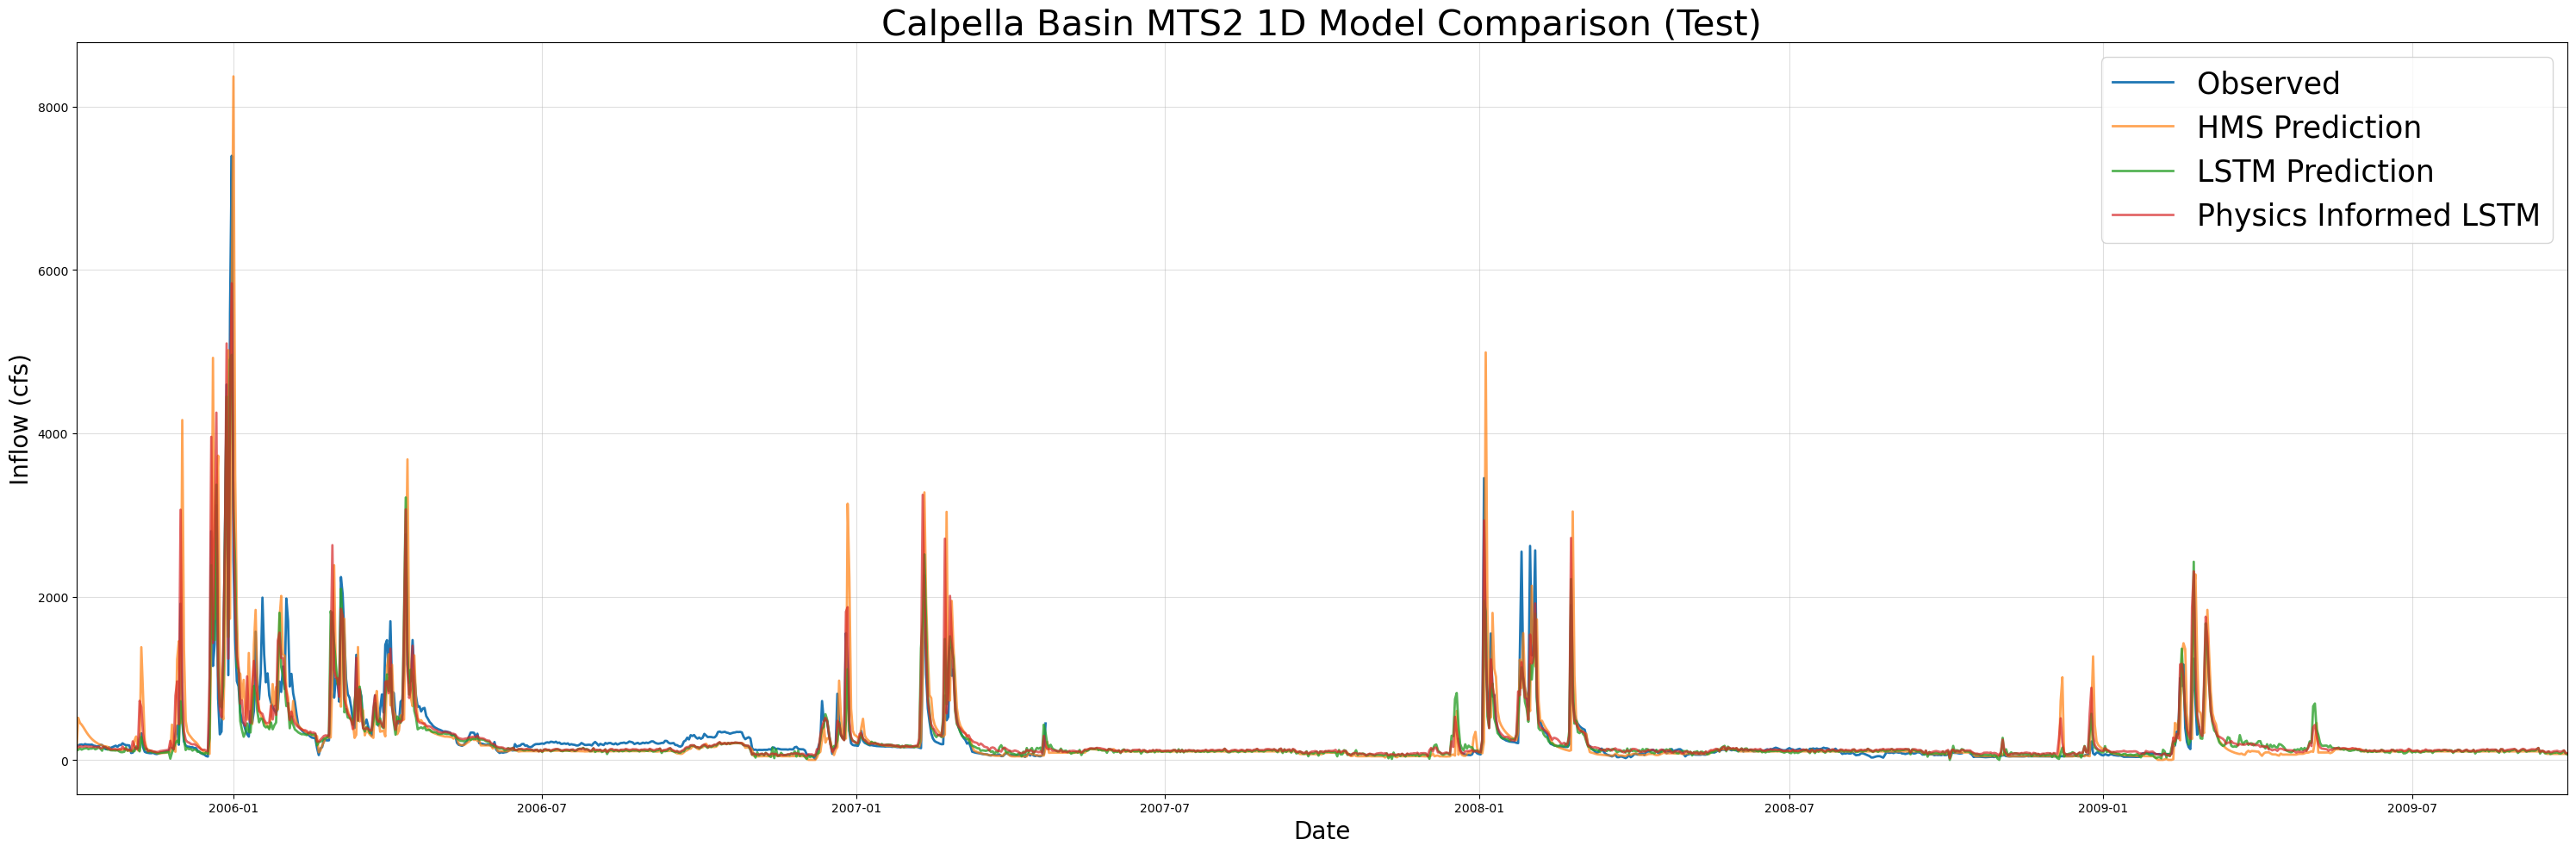

In [61]:
if not skip_best_model_train:
    print("\nPlotting combined MTS2 results (Test, 1D)...")
    combinedPlot(
        lstm_results=no_physics_test_csv_1D,
        lstmPhysics_results=physics_test_csv_1D,
        HMS_results=path_to_physics_data_1D,
        title="Calpella Basin MTS2 1D Model Comparison (Test)",
        fName="calpella_mts2_test_metrics_1D.csv",
        plot_filename="calpella_mts2_test_1D_comparison.png",
        timeseries_filename="calpella_mts2_test_1D_combined_ts.csv"
    )
else:
    combined_df_test_1D = pd.read_csv("calpella_mts2_test_1D_combined_ts.csv")
    combinedPlotFromDf(
        combined_df_test_1D,
        title="Calpella Basin MTS2 1D Model Comparison (Test)",
        fName="calpella_mts2_test_metrics_1D.csv"
    )

In [62]:
if not skip_best_model_train:
    fancyCombinedPlot(
        lstm_results=no_physics_test_csv_1D,
        lstmPhysics_results=physics_test_csv_1D,
        HMS_results=path_to_physics_data_1D,
        title="Calpella Basin MTS2 1D Model Comparison (Test)",
        fName="calpella_mts2_test_metrics_1D.csv",
        timeseries_filename="calpella_mts2_test_1D_combined_ts.csv"
    )
else:
    fancyCombinedPlotFromDf(
        combined_df_test_1D,
        title="Calpella Basin MTS2 1D Model Comparison (Test)",
        fName="calpella_mts2_test_metrics_1D.csv"
    )

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB

[INFO] Wrote metrics CSV: calpella_mts2_test_metrics_1D.csv


[INFO] Wrote metrics CSV: calpella_mts2_test_metrics_1H.csv


/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB

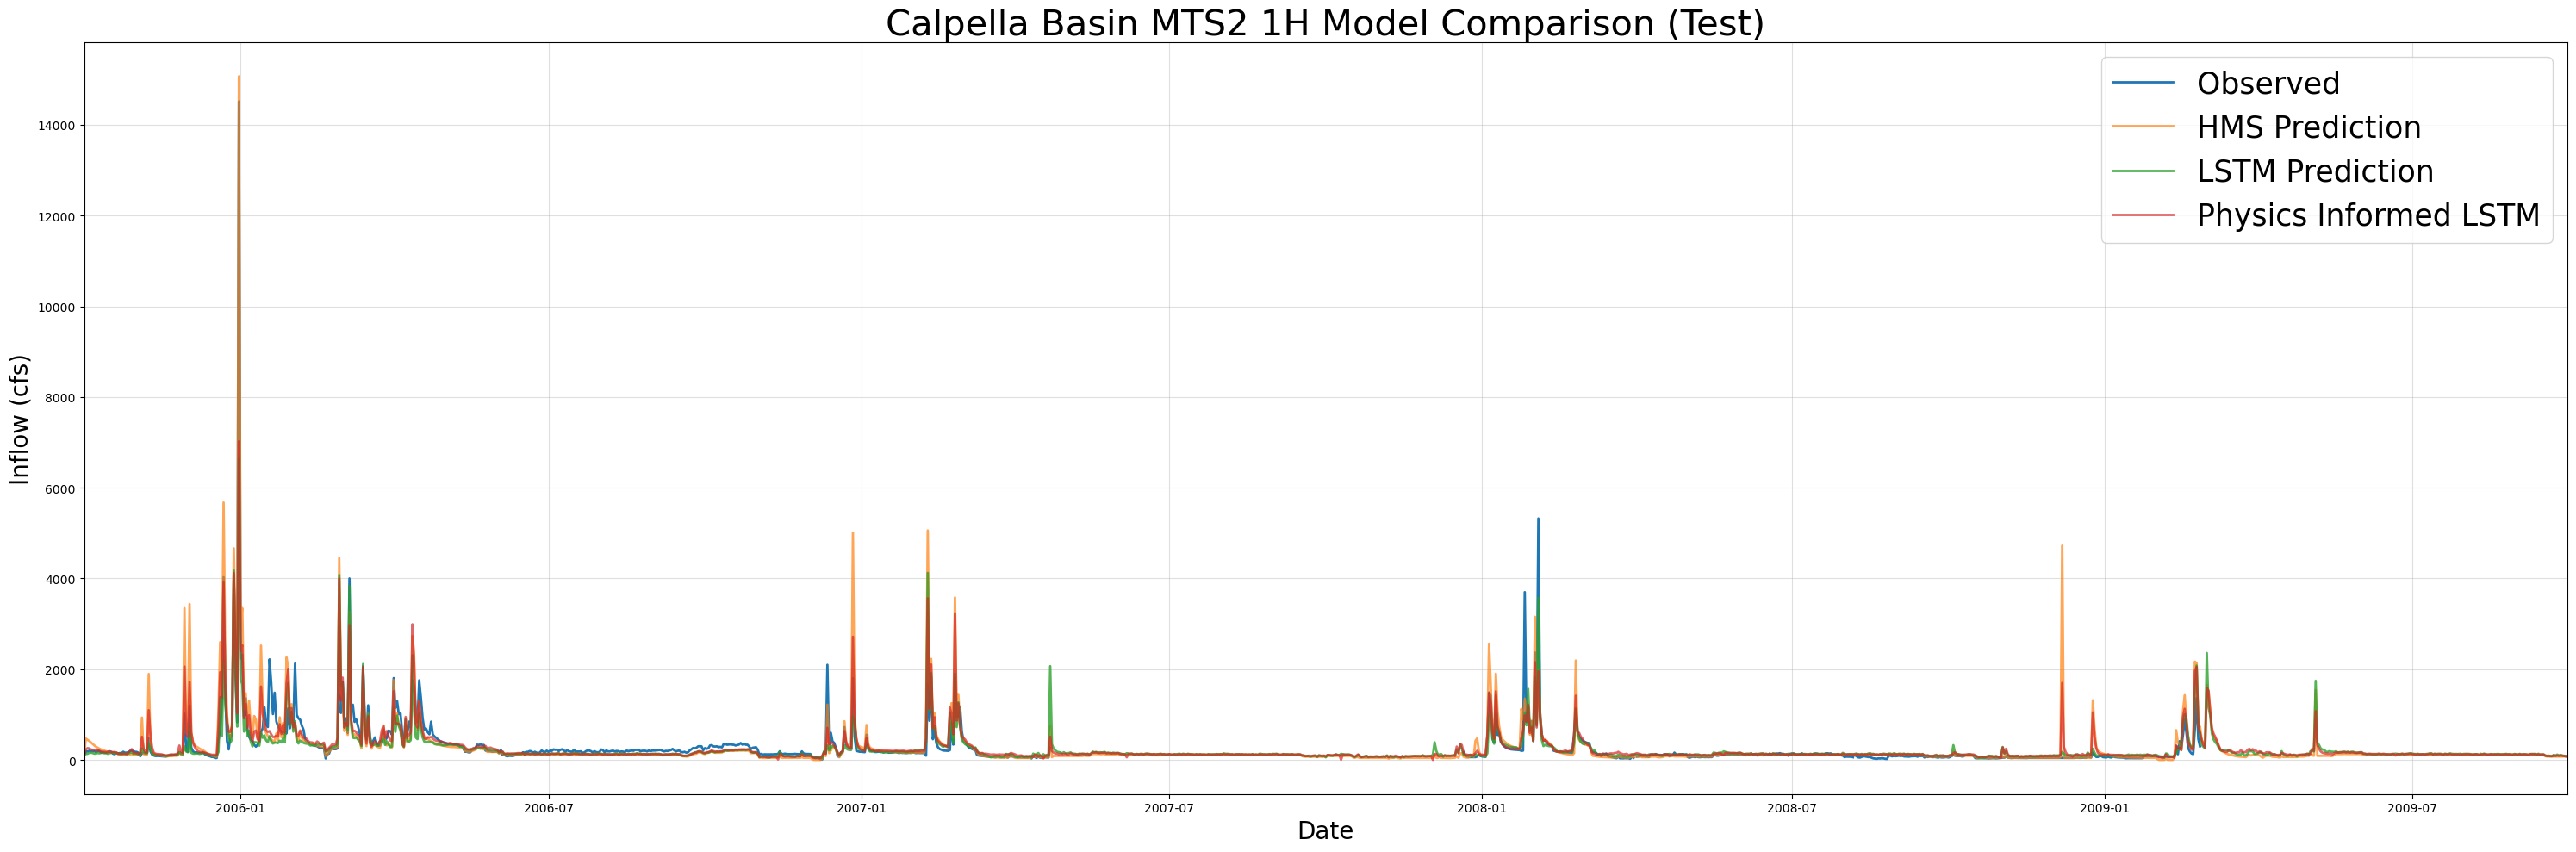

In [63]:
if not skip_best_model_train:
    print("\nPlotting combined MTS2 results (Test, 1H)...")
    combinedPlot(
        lstm_results=no_physics_test_csv_1H,
        lstmPhysics_results=physics_test_csv_1H,
        HMS_results=path_to_physics_data_1H,
        title="Calpella Basin MTS2 1H Model Comparison (Test)",
        fName="calpella_mts2_test_metrics_1H.csv",
        plot_filename="calpella_mts2_test_1H_comparison.png",
        timeseries_filename="calpella_mts2_test_1H_combined_ts.csv"
    )
else:
    combined_df_test_1H = pd.read_csv("calpella_mts2_test_1H_combined_ts.csv")
    combinedPlotFromDf(
        combined_df_test_1H,
        title="Calpella Basin MTS2 1H Model Comparison (Test)",
        fName="calpella_mts2_test_metrics_1H.csv"
    )

In [64]:
if not skip_best_model_train:
    fancyCombinedPlot(
        lstm_results=no_physics_test_csv_1H,
        lstmPhysics_results=physics_test_csv_1H,
        HMS_results=path_to_physics_data_1H,
        title="Calpella Basin MTS2 1H Model Comparison (Test)",
        fName="calpella_mts2_test_metrics_1H.csv",
        timeseries_filename="calpella_mts2_test_1H_combined_ts.csv"
    )
else:
    fancyCombinedPlotFromDf(
        combined_df_test_1H,
        title="Calpella Basin MTS2 1H Model Comparison (Test)",
        fName="calpella_mts2_test_metrics_1H.csv"
    )

[INFO] Wrote metrics CSV: calpella_mts2_test_metrics_1H.csv


/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB

In [65]:
if skip_best_model_train:
    test_metrics = pd.read_csv("calpella_mts2_test_metrics_1D.csv", index_col=0)
    print(test_metrics)

                       HMS          LSTM  Physics_Informed_LSTM
NSE               0.061118      0.821862               0.810758
MSE          239795.347158  45497.476262           48333.325126
RMSE            489.689031    213.301374             219.848414
KGE               0.570135      0.834665               0.896306
Alpha-NSE         1.222509      0.886763               1.014942
Beta-KGE          1.057431      0.922272               1.043803
Beta-NSE          0.033696     -0.045605               0.025700
Pearson-r         0.636716      0.907960               0.907207
FHV              25.602361     -8.868696               6.771644
FMS              -0.155267    -17.678787             -15.615851
FLV            -969.548010   -993.829040              15.902994
Peak-Timing       1.000000      0.200000               0.200000
Peak-MAPE        58.863819     51.469650              30.040771


In [66]:
if skip_best_model_train:
    test_metrics = pd.read_csv("calpella_mts2_test_metrics_1H.csv")
    print(test_metrics)

     Unnamed: 0            HMS           LSTM  Physics_Informed_LSTM
0           NSE       0.668932       0.706456               0.706927
1           MSE  133578.697140  118438.483138          118248.783108
2          RMSE     365.484195     344.148926             343.873208
3           KGE       0.773225       0.642973               0.719740
4     Alpha-NSE       1.170422       0.688709               0.769625
5      Beta-KGE       1.076653       0.896759               1.034853
6      Beta-NSE       0.035578      -0.047918               0.016176
7     Pearson-r       0.871517       0.858906               0.844249
8           FHV      28.558751     -18.090568             -10.031867
9           FMS       1.655551     -24.377881             -13.599998
10          FLV    -977.250642      51.589878             -40.390432
11  Peak-Timing       0.000000       0.000000               0.000000
12    Peak-MAPE      44.087769      51.201696              60.347614



[DEBUG] => Loaded final 1D combined CSV from: calpella_mts2_test_1D_combined_ts.csv
[DEBUG] => final_df shape: (1461, 5)
[DEBUG] => final_df columns: ['Date', 'Observed', 'HMS_Predicted', 'LSTM_Predicted', 'PLSTM_Predicted']
[DEBUG] => Date range: 2005-10-01 00:00:00 to 2009-09-30 00:00:00
[DEBUG] => NaN count:
 Date                 0
Observed           460
HMS_Predicted        0
LSTM_Predicted       0
PLSTM_Predicted      0
dtype: int64

[DEBUG] => Observed stats => mean=296.516, min=11.000, max=7398.792, #points=1001
[DEBUG] => HMS stats => mean=313.545, min=0.000, max=8371.327, #points=1001
[DEBUG] => Pearson r (no shift) = 0.637
[DEBUG] => NSE (no shift) = 0.061
[DEBUG] => Pearson r (HMS +1-day shift) = 0.503
[DEBUG] => NSE (HMS +1-day shift) = -0.266
[DEBUG] => Pearson r (HMS -1-day shift) = 0.900
[DEBUG] => NSE (HMS -1-day shift) = 0.704
[DEBUG] => Ratio of means (HMS/Observed) = 1.057


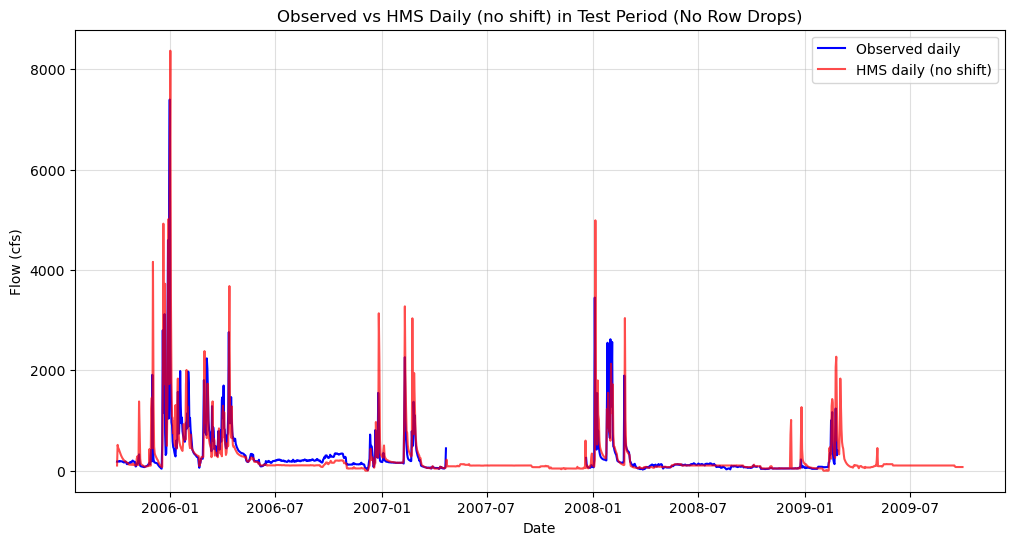


[DEBUG] => Done!


In [67]:
# --------------------------------------------------------------------
# EXTENDED DEBUG CELL WITH NSE CALC, NO ROW-DROPS
# --------------------------------------------------------------------
import pandas as pd
import numpy as np
import os
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def nse(obs_array, sim_array):
    """
    Compute the Nash-Sutcliffe Efficiency (NSE) between two 1D arrays.
    Ignores NaNs on a pairwise basis.
    """
    # Filter to valid (non-NaN) pairs
    valid = ~np.isnan(obs_array) & ~np.isnan(sim_array)
    obs_val = obs_array[valid]
    sim_val = sim_array[valid]

    if len(obs_val) < 2:
        return np.nan  # Not enough data to compute NSE

    numerator = np.sum((obs_val - sim_val) ** 2)
    denominator = np.sum((obs_val - np.mean(obs_val)) ** 2)
    return 1 - (numerator / denominator)

debug_1d_csv = "calpella_mts2_test_1D_combined_ts.csv"  # or e.g. "calpella_mts2_val_1D_combined_ts.csv"
if not os.path.exists(debug_1d_csv):
    print(f"[DEBUG] => The file {debug_1d_csv} does not exist. Did you generate it already?")
else:
    final_df = pd.read_csv(debug_1d_csv)
    print("\n[DEBUG] => Loaded final 1D combined CSV from:", debug_1d_csv)
    print("[DEBUG] => final_df shape:", final_df.shape)
    print("[DEBUG] => final_df columns:", final_df.columns.tolist())

    # Convert to datetime
    final_df["Date"] = pd.to_datetime(final_df["Date"], errors="coerce")

    # We'll focus on these columns
    daily_cols = ["Observed", "HMS_Predicted", "LSTM_Predicted", "PLSTM_Predicted"]
    for col in daily_cols:
        final_df[col] = pd.to_numeric(final_df[col], errors="coerce")

    print("[DEBUG] => Date range:", final_df["Date"].min(), "to", final_df["Date"].max())
    print("[DEBUG] => NaN count:\n", final_df.isna().sum())

    # Sort by date but keep all rows
    sub_df = final_df.sort_values("Date").reset_index(drop=True)

    # Convert to numpy arrays
    obs_vals = sub_df["Observed"].values
    hms_vals = sub_df["HMS_Predicted"].values

    # ------------------------------------------
    # 1) Basic stats (pairwise ignoring NaNs)
    # ------------------------------------------
    valid_noshift = ~np.isnan(obs_vals) & ~np.isnan(hms_vals)
    obs_valid = obs_vals[valid_noshift]
    hms_valid = hms_vals[valid_noshift]

    if len(obs_valid) < 2:
        print("\n[DEBUG] => Not enough valid overlapping data to compute stats or NSE.")
    else:
        obs_mean = obs_valid.mean()
        obs_min = obs_valid.min()
        obs_max = obs_valid.max()

        hms_mean = hms_valid.mean()
        hms_min = hms_valid.min()
        hms_max = hms_valid.max()

        print("\n[DEBUG] => Observed stats =>",
              f"mean={obs_mean:.3f}, min={obs_min:.3f}, max={obs_max:.3f}, #points={len(obs_valid)}")
        print("[DEBUG] => HMS stats =>",
              f"mean={hms_mean:.3f}, min={hms_min:.3f}, max={hms_max:.3f}, #points={len(hms_valid)}")

        # ------------------------------------------
        # 2) Pearson correlation (no shift), ignoring NaNs pairwise
        # ------------------------------------------
        r_noshift, _ = pearsonr(obs_valid, hms_valid)
        print(f"[DEBUG] => Pearson r (no shift) = {r_noshift:.3f}")

        # ------------------------------------------
        # 3) Compute NSE (no shift)
        # ------------------------------------------
        nse_noshift = nse(obs_vals, hms_vals)  # this function also ignores NaNs pairwise
        print(f"[DEBUG] => NSE (no shift) = {nse_noshift:.3f}")

        # ------------------------------------------
        # 4) SHIFT ±1 DAY to see if correlation & NSE improve
        # ------------------------------------------
        # We'll shift the entire hms_vals array and then do pairwise ignoring again.
        hms_shift_plus1 = np.roll(hms_vals, 1)  # forward by 1 day
        hms_shift_plus1[0] = np.nan  # so the first day doesn't artificially match

        hms_shift_minus1 = np.roll(hms_vals, -1)  # backward by 1 day
        hms_shift_minus1[-1] = np.nan

        # (A) +1 day shift
        r_plus1 = np.nan
        nse_plus1 = np.nan
        valid_plus1 = ~np.isnan(obs_vals) & ~np.isnan(hms_shift_plus1)
        if valid_plus1.sum() > 1:
            r_plus1, _ = pearsonr(obs_vals[valid_plus1], hms_shift_plus1[valid_plus1])
            nse_plus1 = nse(obs_vals, hms_shift_plus1)
        print(f"[DEBUG] => Pearson r (HMS +1-day shift) = {r_plus1:.3f}")
        print(f"[DEBUG] => NSE (HMS +1-day shift) = {nse_plus1:.3f}")

        # (B) -1 day shift
        r_minus1 = np.nan
        nse_minus1 = np.nan
        valid_minus1 = ~np.isnan(obs_vals) & ~np.isnan(hms_shift_minus1)
        if valid_minus1.sum() > 1:
            r_minus1, _ = pearsonr(obs_vals[valid_minus1], hms_shift_minus1[valid_minus1])
            nse_minus1 = nse(obs_vals, hms_shift_minus1)
        print(f"[DEBUG] => Pearson r (HMS -1-day shift) = {r_minus1:.3f}")
        print(f"[DEBUG] => NSE (HMS -1-day shift) = {nse_minus1:.3f}")

        # ------------------------------------------
        # 5) Check ratio of means => aggregator mismatch?
        # ------------------------------------------
        ratio_mean = hms_mean / obs_mean if obs_mean != 0 else np.nan
        print(f"[DEBUG] => Ratio of means (HMS/Observed) = {ratio_mean:.3f}")
        if ratio_mean > 10 or ratio_mean < 0.1:
            print("[WARNING] => The ratio of means is suspiciously large or small. Possible aggregator mismatch!")

        # ------------------------------------------
        # 6) Optional small plot for visual check
        # ------------------------------------------
        plt.figure(figsize=(12,6))
        plt.plot(sub_df["Date"], obs_vals, label="Observed daily", color="blue")
        plt.plot(sub_df["Date"], hms_vals, label="HMS daily (no shift)", color="red", alpha=0.7)
        plt.legend()
        plt.title("Observed vs HMS Daily (no shift) in Test Period (No Row Drops)")
        plt.xlabel("Date")
        plt.ylabel("Flow (cfs)")
        plt.grid(True, alpha=0.4)
        plt.show()

    print("\n[DEBUG] => Done!")